# List 2

In [68]:
from datetime import timedelta, date
from matplotlib.animation import FuncAnimation
import imaplib
from pydantic_settings import BaseSettings,SettingsConfigDict
from emails.gmail import  GmailIMAP
from emails.model import  Response
from typing import Any
from functools import lru_cache
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import calendar
import networkx as nx
from pyvis.network import Network
import utils
from utils import with_pickle, with_pickle_async
from matplotlib.colors import to_hex
import spacy
from wordcloud import WordCloud
from googletrans import Translator
from tqdm import tqdm
import asyncio
from tqdm.asyncio import tqdm_asyncio
from collections import Counter
from text_processing import word_difficulty
import sys
import nltk
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [5]:
nlp = spacy.load("pl_core_news_md")

In [6]:
MAILS_TO_DOWNLOAD_COUNT = [6000]
BATCH_SIZE = 200

In [7]:
class UserAuth(BaseSettings):
    model_config = SettingsConfigDict(frozen=True, env_file=".env", env_prefix="gmail_")
    
    user: str
    password: str
    imap_url: str = "imap.gmail.com"
    
    @property
    def connection(self):
        return imaplib.IMAP4_SSL(self.imap_url) 
    

In [8]:
USER_AUTH = UserAuth()

In [9]:
def get_message_count(manager: GmailIMAP) -> int:
    resp = manager.select("INBOX")
    if not resp.ok:
        raise SystemExit("Cannot open INBOX")
    return resp.message_count

In [10]:
@lru_cache(maxsize=1)
def get_messages(manager: GmailIMAP, count: int = 100, batch_size: int = 20):
    messages = []
    messages_no = min(count, get_message_count(manager))
    fails_coutner = 0
    print(f"Messages to read: {messages_no}.")
    for i in range (1, messages_no + 1, batch_size):
        responses = manager.fetch_messages(range(i, i + batch_size))
        for resp in responses:
            if resp.ok and resp.message:
                messages.append(resp)
            else:
                fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

# (Task 1 & 2) Frequency analysis

In [11]:
def analyze_freq_pattern(manager: GmailIMAP, message_max_limit: int = 100, batch_size: int = 100):
    messages = get_messages(manager, message_max_limit, batch_size)
    dates = pl.DataFrame({"Time": [m.message.date for m in messages]})
    return dates


In [12]:
# %%time
# MAILS_TO_DOWNLOAD = 1000 
# BATCH_SIZE = 100
# imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
# dates = analyze_freq_pattern(imap, MAILS_TO_DOWNLOAD, BATCH_SIZE)
# imap.conn.logout()

In [13]:
is_written: bool = True
if not is_written: 
    with Path("data/dates.pkl").open("wb") as f:
        pickle.dump(dates, f)
else:
    with Path("data/dates.pkl").open("rb") as f:
        dates = pickle.load(f)

In [14]:
# daily_hist = (
#     dates
#     .with_columns(pl.col("Time").dt.truncate("1d").alias("day"))
#     .group_by("day")
#     .agg(pl.len().alias("count"))
#     .sort("day")
# )

daily_hist = (
    dates
    .sort("Time")
    .group_by_dynamic(
        index_column="Time",
        every="1d",
        closed="left"
    )
    .agg(pl.len().alias("count"))
)

daily_pattern = (
    dates
    .with_columns(pl.col("Time").dt.hour().alias("hour"))
    .group_by("hour")
    .agg(pl.len().alias("count"))
    .sort("hour")
)

monthly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.month().alias("month"))
    .group_by("month")
    .agg(pl.len().alias("count"))
    .sort("month")
)


weekly_pattern = (
    dates
    .with_columns(pl.col("Time").dt.weekday().alias("day"))
    .group_by("day")
    .agg(pl.len().alias("count"))
    .sort("day")
)
daily_pattern
monthly_pattern

month,count
i8,u32
1,122
2,127
3,155
4,96
5,57
…,…
8,7
9,19
10,153


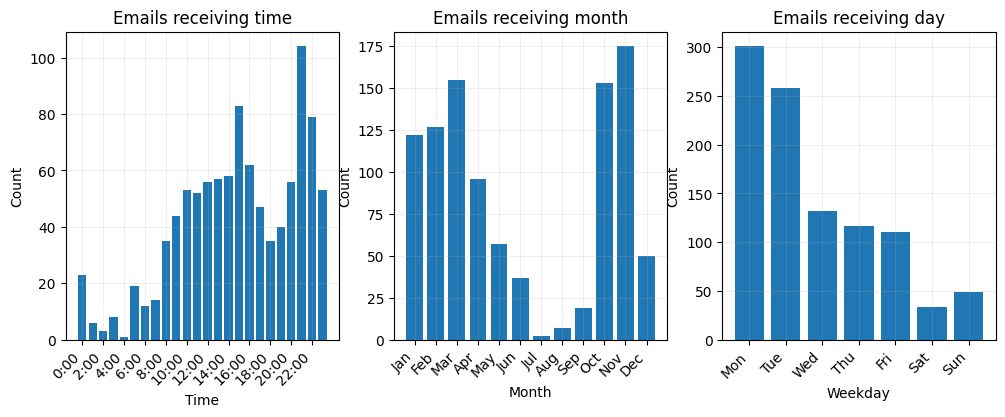

In [15]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
ax = axes.flatten()[0]
ax.bar(daily_pattern["hour"], daily_pattern["count"])
ax.set_xlabel("Time")
ax.set_ylabel("Count")
ax.set_title("Emails receiving time")
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels((f"{i}:00" for i in range(0, 24, 2)), rotation=45, ha="right")
ax.grid(alpha=0.2)

ax = axes.flatten()[1]
month_names = list(calendar.month_abbr)[1:] # For some reason the first value is an additional empty string
ax.bar(monthly_pattern["month"], monthly_pattern["count"])
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Emails receiving month")
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


ax = axes.flatten()[2]
weekday_names = list(calendar.day_abbr)
ax.bar(weekly_pattern["day"], weekly_pattern["count"])
ax.set_xlabel("Weekday")
ax.set_ylabel("Count")
ax.set_title("Emails receiving day")
ax.set_xticks(range(1,8))
ax.set_xticklabels(weekday_names, rotation=45, ha="right")
ax.grid(alpha=0.2)


# (Task 3) Emails volume

In [16]:
daily_volume = (
    daily_hist
    .with_columns(
        pl.col("count").cum_sum().alias("cumulative_count")
    )
)

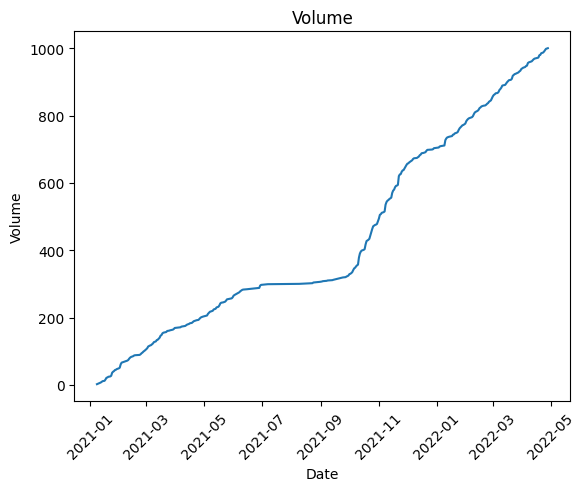

In [17]:

plt.plot(daily_volume["Time"], daily_volume["cumulative_count"])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume")
plt.xticks(rotation=45)
plt.show()

# (Task 4) Network graph

In [18]:
def get_message_count(manager: GmailIMAP, dir: str) -> int:
    resp = manager.select(dir)
    if not resp.ok:
        msg = f"Cannot open {dir}"
        raise SystemExit(msg)
    return resp.message_count

@with_pickle()
def get_messages(manager: GmailIMAP, limits: tuple[int] = [80], batch_size: int = 20):
    # dirs = ["INBOX"]
    dirs = ["[Gmail]/Wszystkie"]
    if len(limits) != len(dirs):
        msg = "Limits number must corresponds with number of directories."
        raise ValueError(msg)
    dirs_n_limits = zip(dirs, limits, strict=True)
    messages = []
    fails_coutner = 0
    for d, l in dirs_n_limits:
        print(f"Reading from: {d}")
        messages_no = get_message_count(manager, d)
        print(f"Found {messages_no} in total.")
        messages_no = min(messages_no, l)
        print(f"Messages to read: {messages_no}.")
        manager.select(d)
        for i in range (1, messages_no + 1, batch_size):
            responses = manager.fetch_messages(range(i, i + batch_size))
            for resp in responses:
                if resp.ok and resp.message:
                    messages.append(resp)
                else:
                    fails_coutner += 1
    print(f"Successfully read {len(messages)}.")
    print(f"Fails with {fails_coutner}.")
    return messages

In [19]:
import re
email_regex = re.compile(r" *<([^>]+)> *")
def _get_user(text: str) -> str:
    return re.sub(email_regex, "", text)

from itertools import chain
import hashlib
def _get_hash(text: str) -> str:
    return hashlib.sha1(text.encode("utf-8")).hexdigest()[-6:]
# list(chain.from_iterable([["Ania"], ["Bania", "Hania"]]))

In [20]:

def get_senders(manager: GmailIMAP, *args, **kwargs):
    messages = get_messages(manager, *args, **kwargs)
    return pl.DataFrame({
        "Hash" : [_get_hash(m.message.subject) for m in messages],
        "Date" : [m.message.date for m in messages],
        "Sender": [m.message.sender for m in messages],
        "Sender_count": [len(m.message.sender) for m in messages],
        "Receiver": [m.message.to for m in messages],
        "Receiver_count": [len(m.message.to) for m in messages],
        "CC": [m.message.cc for m in messages],
        "CC_count": [len(m.message.cc) for m in messages],
        "BCC": [m.message.bcc for m in messages],
        "BCC_count": [len(m.message.bcc) for m in messages],
    })

def get_relations(senders: pl.DataFrame) -> pl.DataFrame:
    return (
        senders
        .explode("Sender")
        .explode("Receiver")
        .explode("CC")
        .explode("BCC")
        .with_columns([
            pl.when(pl.col("Receiver").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Receiver"))
            .alias("Receiver"),
            
            pl.when(pl.col("Sender").str.contains(r"262290|Jankowski"))
            .then(pl.lit("Me"))
            .otherwise(pl.col("Sender"))
            .alias("Sender"),
        ])
        .filter(
            ~pl.col("Receiver").str.contains(r"wielu adresatów")
        )
        # Remove artifacts
        .filter(
            ~(pl.col("Receiver").str.contains(r"Osobka") & pl.col("Sender").str.contains(r"Osobka"))
        )
        .filter(
            ~(pl.col("Receiver").str.contains(r"test-group") & pl.col("Sender").str.contains(r"botdatabase"))
        )
    )

def create_graph(relations: pl.DataFrame) -> nx.Graph:
    unique_relations = relations.unique([pl.col("Sender"), pl.col("Receiver"), pl.col("CC"), pl.col("BCC")])
    unique_relations = unique_relations.filter(pl.col("Receiver").is_not_null())
    print(f"Unique rows: {len(unique_relations)}")
    edges = list(zip(unique_relations["Sender"], unique_relations["Receiver"]))
    from pyvis.network import Network
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=False, node_color="lightblue", node_size=15, font_size=12)
    net = Network(
        directed = False,
        select_menu = True,
        filter_menu = True,
    )
    net.show_buttons()
    net.from_nx(G)
    net.save_graph('communicatio_graph.html')
    return G


In [21]:
def filter_by_date(frame: pl.DataFrame, upper_threshold_date: pl.date) -> pl.DataFrame:
    return (
        frame
        .filter(pl.col("Date") < upper_threshold_date)
    )

In [22]:

def update_graph(g: nx.Graph, relations: pl.DataFrame) -> nx.Graph:
    unique_relations = relations.unique([pl.col("Sender"), pl.col("Receiver"), pl.col("CC"), pl.col("BCC")])
    unique_relations = unique_relations.filter(pl.col("Receiver").is_not_null())
    edges = list(zip(unique_relations["Sender"], unique_relations["Receiver"]))
    g.add_edges_from(edges)
    return g


In [23]:

class Animation:
    def __init__(self) -> None:
        self.graph = None
        self.relations_evolutions = None
                
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        self.fig = fig
        ax.set_title("Network Growth Over Time")
        ax.axis("off")
        self.ax = ax
        
    def update_animation(self, frame_idx):
        self.graph.clear()
        update_graph(self.graph, self.relations_evolutions[frame_idx])

        self.ax.clear()
        self.ax.set_title(f"Network Growth Over Time:\n{frame_idx}")
        self.ax.axis("off")
        
        self.pos = (
            nx.spring_layout(self.graph, seed=42)
            if self.pos == {}
            else
            nx.spring_layout(self.graph, pos=self.pos, seed=42)
        )

        nx.draw_networkx(
            self.graph,
            pos=self.pos,
            ax=self.ax,
            node_color='skyblue',
            edge_color='gray',
            with_labels=False,
            node_size=100,
        )

        
    
    def set_graph(self, g: nx.Graph, relations: list[str]) -> None:
        self.graph = g
        self.pos = nx.spring_layout(self.graph, seed=42)
        self.relations_evolutions = relations
    

    def save_animate(self) -> None:
        anim = FuncAnimation(
            self.fig,
            self.update_animation,
            frames=len(self.relations_evolutions),
            interval=1000,
            blit=False
        )
        anim.save("network_growth.gif", writer="pillow", fps=1)
        print("✅ Saved animation as 'network_growth.gif'")


Unique rows: 2416


('BYE', [b'LOGOUT Requested'])

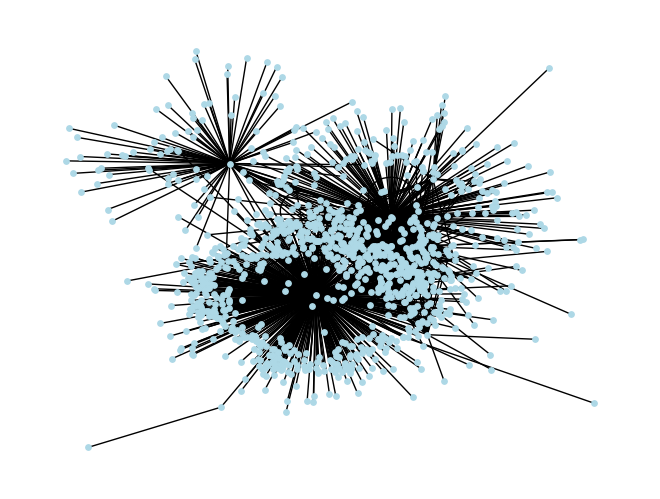

In [24]:
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
senders = get_senders(imap, MAILS_TO_DOWNLOAD_COUNT, BATCH_SIZE, pickle_path="data/all_mails.pkl")
relations = get_relations(senders)
relations_graph = create_graph(relations)
imap.conn.logout()

# (Task 6) Network evolution

Starting building animation...
✅ Saved animation as 'network_growth.gif'


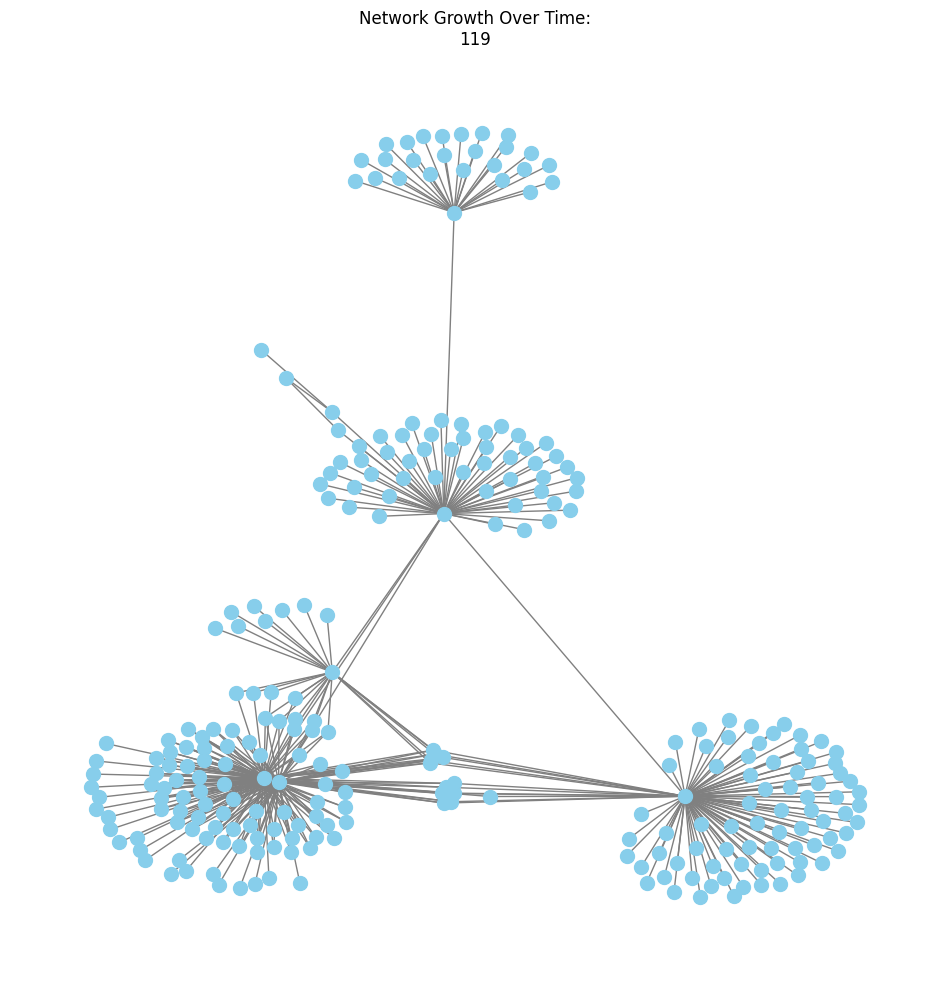

In [25]:

def create_growth_process_graph():
    min_date, max_date = relations["Date"].min().date(), relations["Date"].max().date()
    steps = relations["Date"].dt.date().unique()
    anim_steps = 120
    dates = relations["Date"].dt.date().unique().sort()[:anim_steps]
    # last_step_date = relations["Date"].dt.date().unique().sort()[znim_steps]
    # step_length = (max_date - min_date).days // anim_steps
    # dates = [min_date + timedelta(days=i * step_length) for i in range(anim_steps + 1)]
    g = nx.Graph()
    rel_evolution = [filter_by_date(relations, d) for d in dates]
    anim = Animation()
    anim.set_graph(g, rel_evolution)
    print("Starting building animation...")
    anim.save_animate()
    return g

rel_graph_evolution = create_growth_process_graph()

In [26]:
def get_g_stats(g: nx.Graph):
    return pl.DataFrame({
        "my_contacts": g.degree["Me"],
        "clustering": nx.average_clustering(g),
        "bc": nx.betweenness_centrality(g)["Me"],
        "radius": nx.radius(g),
        "diameter": nx.diameter(g),
        "top_vs": ",".join([_get_user(k) for k, v in sorted(g.degree(), key=lambda item: item[1], reverse=True)[:3]]),
    })

# (Task 5) Key contacts and communication clusters

In [27]:
combined_df = pl.concat([
    relations.filter(pl.col("Receiver") == "Me").select(pl.col("Sender")),
    relations.filter(pl.col("Sender") == "Me").select(pl.col("Receiver").alias("Sender"))
])

combined_df.group_by("Sender").agg(pl.len()).sort("len", descending=True).head(10)


Sender,len
str,u32
"""Medium Daily Digest <noreply@m…",767
"""The Medium Newsletter <newslet…",288
"""edukacja@pwr.edu.pl""",277
"""DataCamp <team@datacamp.com>""",203
"""DataCamp Insights <team@dataca…",183
"""Google Flights <noreply-travel…",155
"""Academia.edu <premium@academia…",150
"""ResearchGate <no-reply@researc…",136
"""JSOS <admin_jsos@pwr.edu.pl>""",111


In [28]:

def draw_communication_clusters(graph: nx.Graph, level: int = 1) -> None:
    if level > 5:
        msg = "allowed maximum 5 levels."
        raise ValueError(msg)
    colors = ["red", "green", "blue", "magenta", "lightblue"]
    colors = ["#FF0000", "#00FF00", "#0000FF", "#FF00FF", "#00FFFF", "#bb9949"]
    communities_generator = nx.community.girvan_newman(graph)
    for _ in range(level - 1):
        next(communities_generator)
    communities = list(next(communities_generator))
    node_colors: list[str] = []

    node_colors_dict: dict[str, str] = {}
    for idx, community in enumerate(communities):
        for node in community:
            node_colors_dict[node] = colors[idx]

    pos = nx.spring_layout(graph, seed=42)
    nx.draw(
        graph,
        with_labels=False,
        node_color=[node_colors_dict[node] for node in graph.nodes()],
        node_size=15,
        font_size=12,
        pos=pos,
    )
    net = Network(directed=True, select_menu=True, filter_menu=True)
    for node in graph.nodes():
        net.add_node(node, label=str(node), color=node_colors_dict[node])
    for edge in graph.edges():
        net.add_edge(edge[0], edge[1])
    net.show_buttons()
    net.save_graph(f"communities_levels_{level}.html")


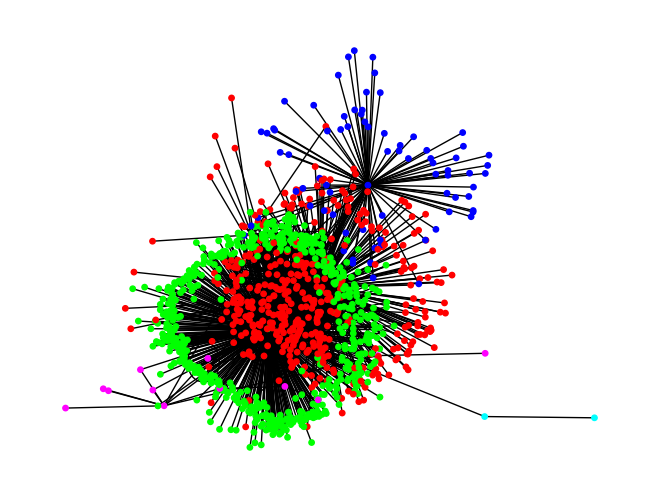

In [29]:
draw_communication_clusters(relations_graph, level=4)

In [30]:
def generate_colors(n: int, cmap_name="tab20"):
    cmap = plt.get_cmap(cmap_name)
    colors = [to_hex(cmap(i / n)) for i in range(n)]
    return colors

In [31]:

def draw_communication_clusters__louvian(graph: nx.Graph, level: int = 1) -> None:
    communities = nx.community.louvain_communities(graph, seed=123, max_level=level)
    colors = generate_colors(len(communities))
    node_colors: list[str] = []

    node_colors_dict: dict[str, str] = {}
    print(communities)
    print(len(communities))
    for idx, community in enumerate(communities):
        for node in community:
            node_colors_dict[node] = colors[idx]

    pos = nx.spring_layout(graph, seed=42)
    nx.draw(
        graph,
        with_labels=False,
        node_color=[node_colors_dict[node] for node in graph.nodes()],
        node_size=15,
        font_size=12,
        pos=pos,
    )
    net = Network(directed=True, select_menu=True, filter_menu=True)
    for node in graph.nodes():
        net.add_node(node, label=str(node), color=node_colors_dict[node])
    for edge in graph.edges():
        net.add_edge(edge[0], edge[1])
    net.show_buttons()
    net.save_graph(f"communities_louvian_levels_{level}.html")


[{'Weronika Kuzara <268763@student.pwr.edu.pl>', 'Eryka Grygutis <262214@student.pwr.edu.pl>', 'Arkadiusz Horodecki <268819@student.pwr.edu.pl>', 'Michał Liszkowski <249712@student.pwr.edu.pl>', 'Katarzyna Podłowska <255682@student.pwr.edu.pl>', 'Dzmitry Pihulski <268954@student.pwr.edu.pl>', 'Adrian Siwak <242084@student.pwr.edu.pl>', 'Natalia Klepacka <262321@student.pwr.edu.pl>', 'Izabela Reszka <268863@student.pwr.edu.pl>', 'Edyta Landkauf <edyta.landkauf@pwr.edu.pl>', 'Iliyasu Tukur <270094@student.pwr.edu.pl>', 'Jakub Gołąb <268807@student.pwr.edu.pl>', 'Alicja Radajewska <268778@student.pwr.edu.pl>', 'Jakub Janik <262313@student.pwr.edu.pl>', 'Łojowski, Adam <262301@student.pwr.edu.pl>', 'Agata Bartosik <252797@student.pwr.edu.pl>', 'Kinga Bełc <249809@student.pwr.edu.pl>', 'Grzegorz Rogoziński <249800@student.pwr.edu.pl>', 'Katarzyna Duszyńska <253395@student.pwr.edu.pl>', 'Michał Jakubowski <249773@student.pwr.edu.pl>', 'Magdalena Wąsik <249704@student.pwr.edu.pl>', 'Patrycja 

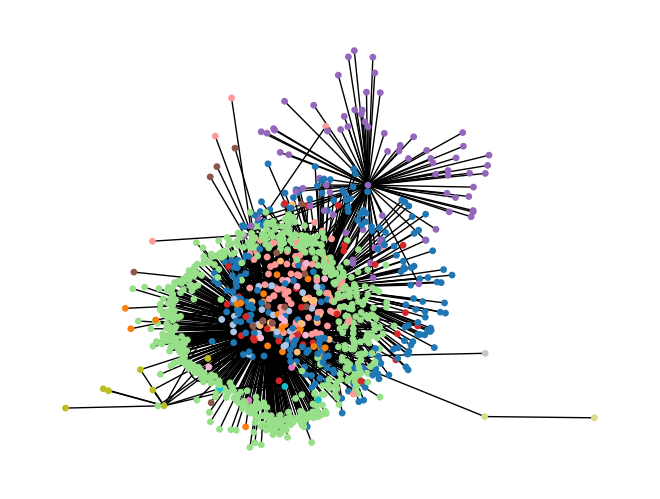

In [32]:
draw_communication_clusters__louvian(relations_graph, level=1)

In [33]:
# G = nx.complete_graph(5)

# K5 = nx.convert_node_labels_to_integers(G, first_label=2)

# G.add_edges_from(K5.edges())

# c = list(nx.community.k_clique_communities(G, 4))

# sorted(list(c[0]))
# [0, 1, 2, 3, 4, 5, 6]

# list(nx.community.k_clique_communities(G, 6))

## (Task 7) Length and complexity over time

In [40]:
def get_message_content(manager: GmailIMAP, *args, **kwargs):
    messages = get_messages(manager, *args, **kwargs)
    return pl.DataFrame({
        "Date": [m.message.date for m in messages],
        "Sender" : [m.message.sender for m in messages],
        "Subject": [m.message.subject for m in messages],
        "Body": [m.message.body for m in messages],
        "Attachments_names": [[a.filename for a in m.message.attachments] for m in messages],
    })

In [41]:
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
contents = get_message_content(imap, MAILS_TO_DOWNLOAD_COUNT, BATCH_SIZE, pickle_path="data/contents.pkl")
imap.conn.logout()

('BYE', [b'LOGOUT Requested'])

In [42]:
my_messages_details = (
    contents
    .explode("Sender")
    .filter(
        (pl.col("Body") != "") & (pl.col("Sender").str.contains(r"262290|Jankowski"))
    )
    .sort(pl.col("Date"))
    .select(["Subject", "Date", "Body"])
    .with_columns([
        (
        pl.col("Body")
        .str.split(" ")
        .list.eval(pl.element().str.to_lowercase())
        .list.unique().list.len()
        /
        pl.col("Body").str.split(" ").list.len()
        ).alias("lexical_diversity"),
        (
            pl.col("Body")
            .str.split(" ")
            .list.len()
            
        ).alias("word_count"),
        (
            pl.col("Body").str.len_chars()
        ).alias("Total lenght")
    ])
)

In [57]:
def extract_tokens(text: str) -> list[str]:
    """Firstly remove all non alphabetic characters, having in mind that
    there are Unicode characters. After tokenization we remove stopwords (ENG+PL)
    and  remove all 1-2 chars lenghts words.

    Finally lemmatize tokens.
    """
    clean = re.sub(r"[\W]+", " ", text.lower())
    clean = re.sub(r"[\d]+", " ", clean)
    words = nltk.word_tokenize(clean)
    words = [w for w in words if w not in word_difficulty.STOPWORDS_PL and len(w) > 2]
    doc = nlp(" ".join(words))
    return [token.lemma_.lower() for token in doc if token.is_alpha]

In [58]:
bodies = my_messages_details["Body"].to_list()
bodies_tokens = []
for b in bodies:
    if not b:
        continue
    bodies_tokens.append(extract_tokens(b))

In [59]:
freq_dict = word_difficulty.build_freqdist()

In [74]:
scaler = MinMaxScaler()
sentense_simplicity: list[float] = []
for tokens in bodies_tokens:
    if len(tokens) == 0:
        sentense_simplicity.append(0.0)
        continue
    sentense_simplicity.append((sum(map(lambda x: freq_dict[x], tokens)) / len(tokens)))

In [83]:
sentense_complexity = 1.0 - scaler.fit_transform(np.array(sentense_simplicity).reshape(-1, 1))
my_messages_details = my_messages_details.with_columns(pl.Series(name="complexity", values=sentense_complexity.reshape(-1))) 

In [88]:
my_messages_details.columns

['Subject',
 'Date',
 'Body',
 'lexical_diversity',
 'word_count',
 'Total lenght',
 'complexity']

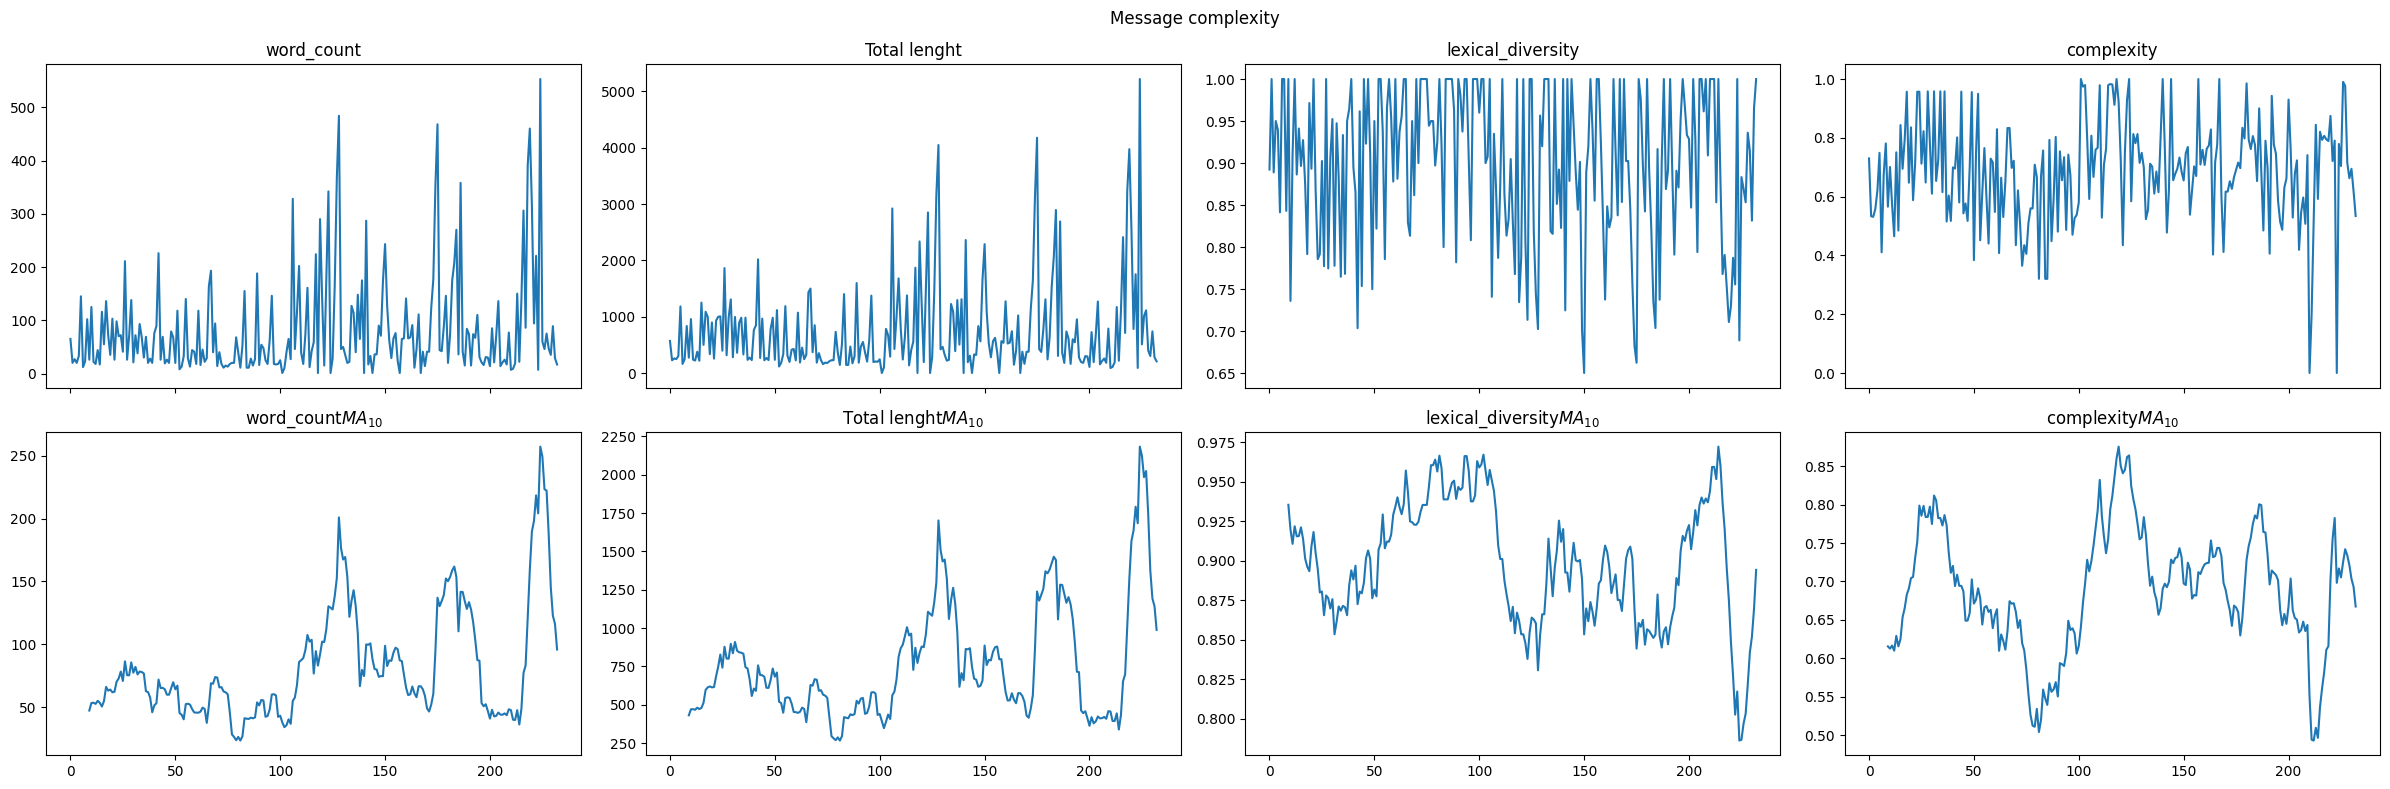

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(24, 8), sharex=True)
# Using dates on Ox provides ugly spaces, because of mailing frequencies

cols = ["word_count", "Total lenght", "lexical_diversity", "complexity"]
for idx, col in enumerate(cols):
    vals = my_messages_details[col]
    current_ax = axs.flatten()[idx]
    current_ax.plot(vals)
    current_ax.set_title(col)

    ma_ax = axs.flatten()[idx+4]
    ma_ax.plot(vals.rolling_mean(window_size=10))
    ma_ax.set_title(f"{col} " + "$MA_{10}$")


plt.suptitle("Message complexity")
plt.tight_layout()

## TODO (Task 8) Average response time

In [101]:
def get_message_content_with_users(manager: GmailIMAP, *args, **kwargs):
    messages = get_messages(manager, *args, **kwargs)
    return pl.DataFrame({
        "Date": [m.message.date for m in messages],
        "Sender" : [m.message.sender for m in messages],
        "Receiver" : [m.message.to for m in messages],
        "Subject": [m.message.subject for m in messages],
        "Body": [m.message.body for m in messages],
        "Attachments_names": [[a.filename for a in m.message.attachments] for m in messages],
    })

In [122]:
imap = GmailIMAP(USER_AUTH.user, USER_AUTH.password)
full_content = get_message_content_with_users(imap, MAILS_TO_DOWNLOAD_COUNT, BATCH_SIZE, pickle_path="data/contents.pkl")
imap.conn.logout()

('BYE', [b'LOGOUT Requested'])

In [125]:
(
    full_content
    .explode("Sender")
    .explode("Receiver")
    .with_columns([
            (pl.col("Date").dt.hour().alias("hour")),
            (pl.col("Date").dt.day().alias("day")),
            (pl.col("Date").dt.month().alias("month")),
    ])
)
# full_content

Date,Sender,Receiver,Subject,Body,Attachments_names,hour,day,month
"datetime[μs, Europe/Warsaw]",str,str,str,str,list[str],i8,i8,i8
2021-01-08 03:59:33 CET,"""Zespół Gmaila <mail-noreply@go…","""262290 262290 <262290@student.…","""Pobierz oficjalną aplikację Gm…","""Pobierz oficjalną aplikację Gm…",[],3,8,1
2021-01-08 03:59:33 CET,"""Zespół Gmaila <mail-noreply@go…","""262290 262290 <262290@student.…","""Wskazówki dotyczące korzystani…","""Wskazówki dotyczące korzystani…",[],3,8,1
2021-01-12 11:32:37 CET,"""Nie odpowiadaj na ten mail (z …","""Jankowski Krzysztof <262290@st…","""Przesłano rozwiązanie do zadan…",""" Algebra liniowa i geometria a…",[],11,12,1
2021-01-12 12:09:57 CET,"""Dział Współpracy Międzynarodow…","""262290@student.pwr.edu.pl""","""Newsletter Działu Współpracy M…",""" …",[],12,12,1
2021-01-12 16:22:13 CET,"""Mariusz Olszewski <mariusz.ols…",null,"""Planowany termin zdalnych zaję…",""" For English scroll down. …","[""ical.ics""]",16,12,1
…,…,…,…,…,…,…,…,…
2025-11-13 07:20:00 CET,"""Medium Daily Digest <noreply@m…","""262290@student.pwr.edu.pl""","""[ZEWNETRZNE] Four Deceitful Da…","""Stories for Krzysztof Jankowsk…",[],7,13,11
2025-11-13 13:02:26 CET,"""DataCamp <team@datacamp.com>""","""262290@student.pwr.edu.pl""","""[ZEWNETRZNE] DataCamp has acqu…","""Try out our AI-native courses …",[],13,13,11
2025-11-13 15:00:48 CET,"""Instant Gaming <newsletter@n.i…","""262290@student.pwr.edu.pl""","""[ZEWNETRZNE] -25% zniżki na An…","""<!DOCTYPE html><html xmlns:v=""…",[],15,13,11


# (Task 9)  Attachments

In [ ]:
attachments = (
    contents
    .explode("Sender")
    .explode("Attachments_names")
    .filter(
        (pl.col("Attachments_names") != "null")
    )
    .select(["Attachments_names"])
)

In [ ]:
extensions = attachments.select(pl.col("Attachments_names").str.replace(r"^.*\.", "").alias("ext"))
# Remove artifacts - probably visual identifiers (characterised by its hude length)
extensions_cleared = extensions.filter(pl.col("ext").str.len_chars() < 5)

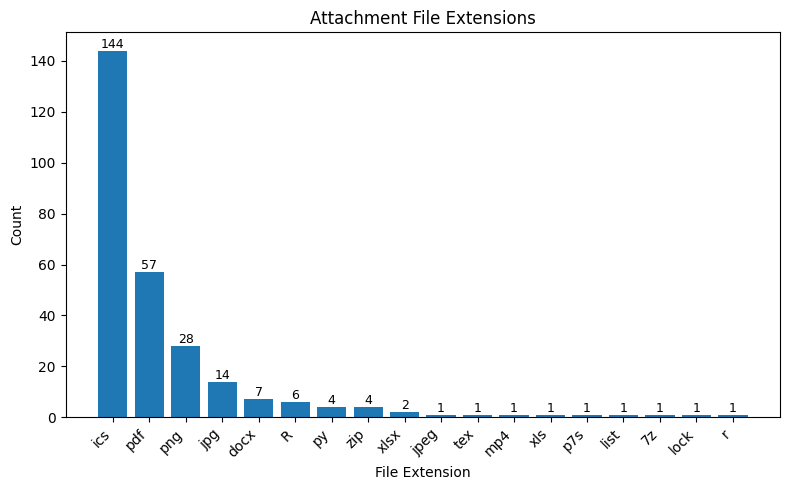

In [ ]:
counts = (
    extensions_cleared
    .group_by("ext")
    .len()
    .sort("len", descending=True)
)
exts = counts["ext"].to_list()
values = counts["len"].to_list()

plt.figure(figsize=(8, 5))
bars = plt.bar(exts, values)

# Add labels on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(value),
        ha='center', va='bottom', fontsize=9
    )

plt.xlabel("File Extension")
plt.ylabel("Count")
plt.title("Attachment File Extensions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Notes: uv.lock + sending on linux without ext

# (Task 10) Common words and phrases in email subjects

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import json
from pathlib import Path

with Path("stopwords-pl.json").open("r") as f:
    stopwords_pl = set(json.load(f))
# nltk.download("stopwords")
# nltk.download('punkt_tab')

In [ ]:
from stopwordsiso import stopwords
stopwords("pl")

{'a',
 'aby',
 'ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'ależ',
 'ani',
 'aż',
 'bardziej',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'bynajmniej',
 'być',
 'był',
 'była',
 'było',
 'były',
 'będzie',
 'będą',
 'cali',
 'cała',
 'cały',
 'chce',
 'choć',
 'ci',
 'ciebie',
 'cię',
 'co',
 'cokolwiek',
 'coraz',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'często',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokąd',
 'dość',
 'dr',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dzisiaj',
 'dziś',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzieś',
 'go',
 'godz',
 'hab',
 'i',
 'ich',
 'ii',
 'iii',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'inż',
 'iv',
 'ix',
 'iż',
 'ja',
 'jak',
 'jakaś',
 'jakby',
 'jaki',
 'jakichś',
 'jakie',
 'jakiś',
 'jakiż',
 'jakkolwiek',
 'jako',
 'jakoś',
 'je',
 'jeden',
 'jedna',
 'jednak',
 'jednakże',
 'jedno',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jemu',

In [ ]:
stopwords_en = set(stopwords.words("english"))
STOPWORDS = stopwords_en | stopwords_pl

In [ ]:
subjects = contents["Subject"].to_list()
tokens = []
for s in subjects:
    if not s:
        continue
    tokens.extend(extract_tokens(s))


In [ ]:
@with_pickle_async()
async def translate_from_pl(words: list[str]) -> list[str]:
    async with Translator() as translator:
        async def translate_one(w):
            t = await translator.translate(w, src="pl", dest="en")
            return t.text
        return await tqdm_asyncio.gather(
            *(translate_one(w) for w in words)
        )

In [ ]:
translations = await translate_from_pl(tokens, pickle_path="data/subjects_words_translations.pkl")

In [ ]:
top10 = Counter(tokens).most_common(10)
top_words, top_counts = zip(*top10)

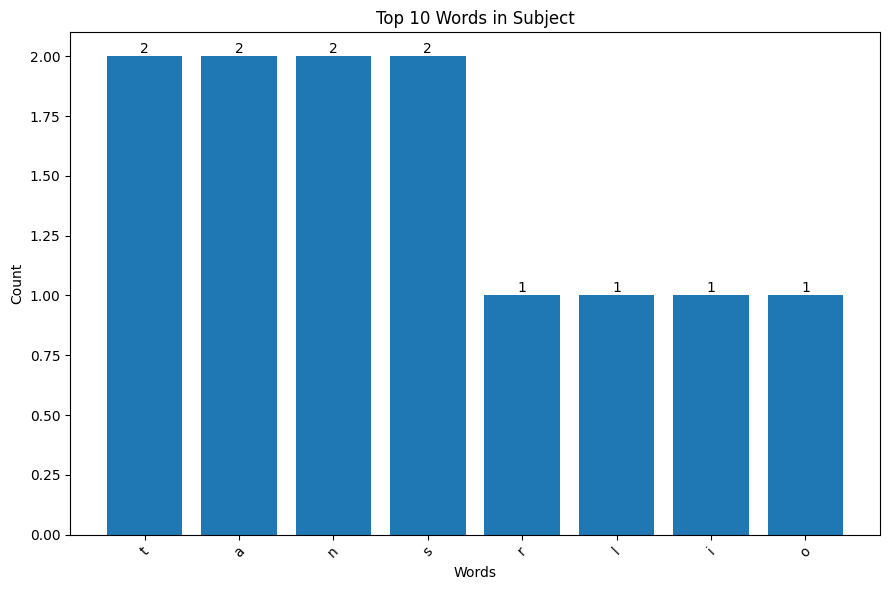

In [ ]:
plt.figure(figsize=(9, 6))
bars = plt.bar(top_words, top_counts)

# Add numbers above bars
for bar, count in zip(bars, top_counts):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(count),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 10 Words in Subject")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


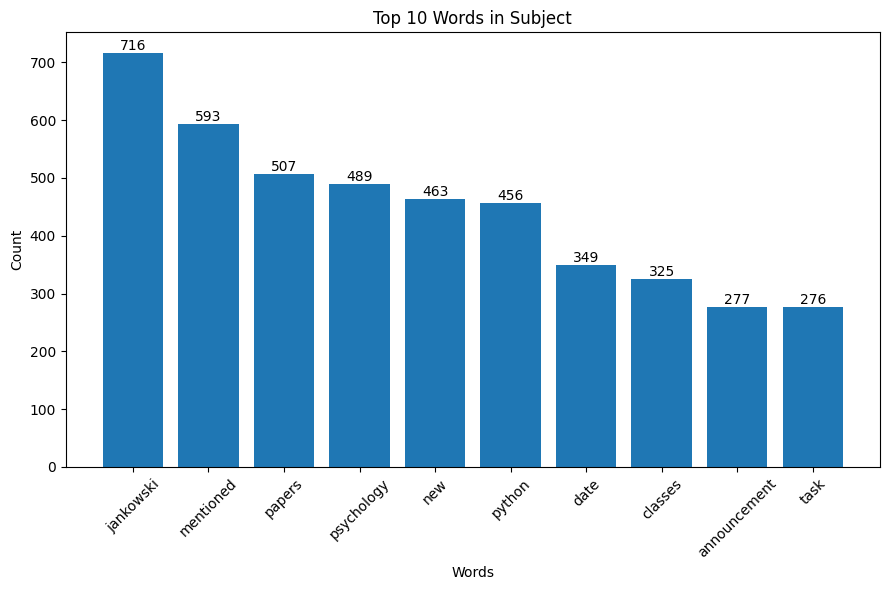

In [ ]:
top10 = Counter(translations).most_common(10)
top_words, top_counts = zip(*top10)

plt.figure(figsize=(9, 6))
bars = plt.bar(top_words, top_counts)

# Add numbers above bars
for bar, count in zip(bars, top_counts):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(count),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 10 Words in Subject")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


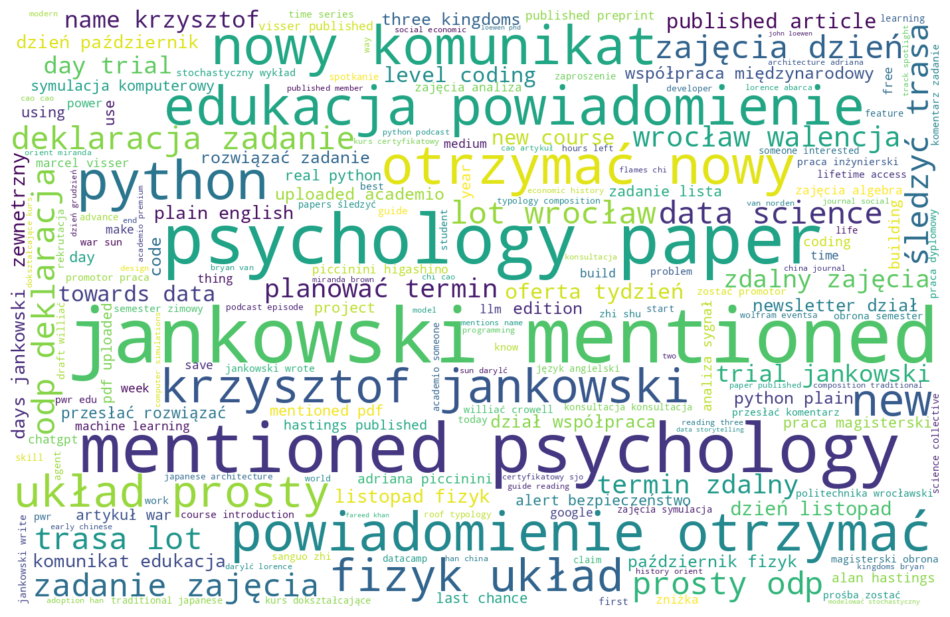

In [ ]:
text = " ".join(tokens)

wc = WordCloud(
    width=1400,
    height=900,
    background_color="white"
).generate(" ".join(tokens))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

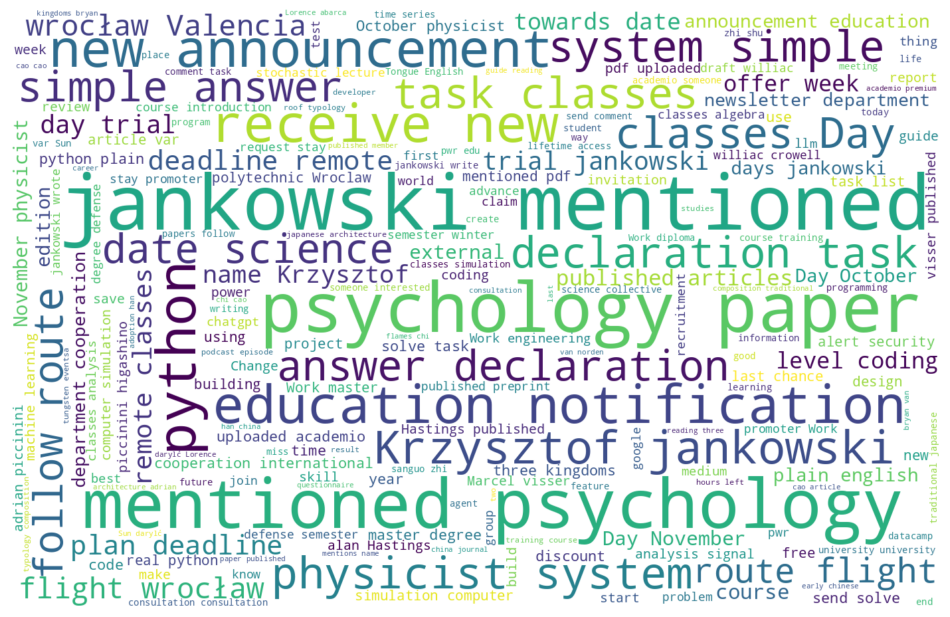

In [ ]:
wc = WordCloud(
    width=1400,
    height=900,
    background_color="white"
).generate(" ".join(translations))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from nltk.util import ngrams
from collections import Counter
import networkx as nx

bigrams = list(ngrams(tokens, 2))  # 2-gramy
bigram_counts = Counter(bigrams).most_common(40)

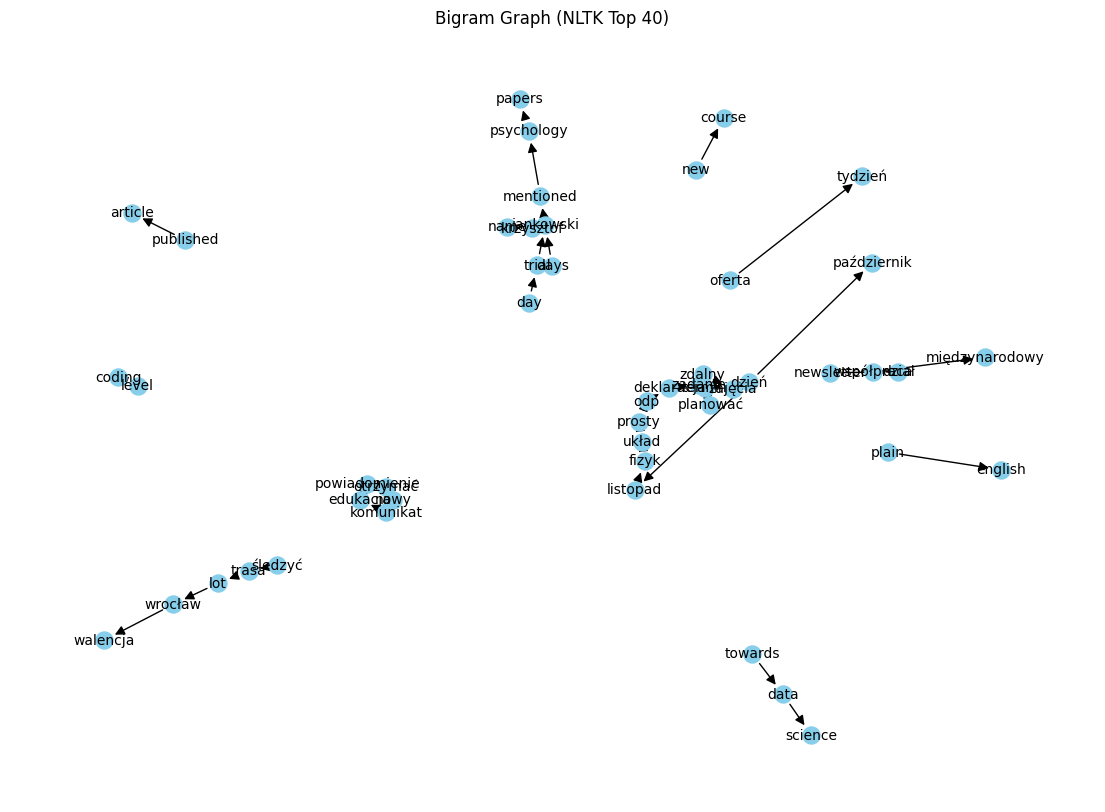

In [ ]:
plt.figure(figsize=(14, 10))

G = nx.DiGraph()
for (w1, w2), count in bigram_counts:
    G.add_edge(w1, w2, weight=count)

pos = nx.spring_layout(G, k=0.5)

nx.draw_networkx_nodes(G, pos, node_size=150, node_color="skyblue")
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=14)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Bigram Graph (NLTK Top 40)")
plt.axis("off")
plt.show()



In [ ]:
trigrams = list(ngrams(tokens, 3))
trigram_counts = Counter(trigrams).most_common(30)

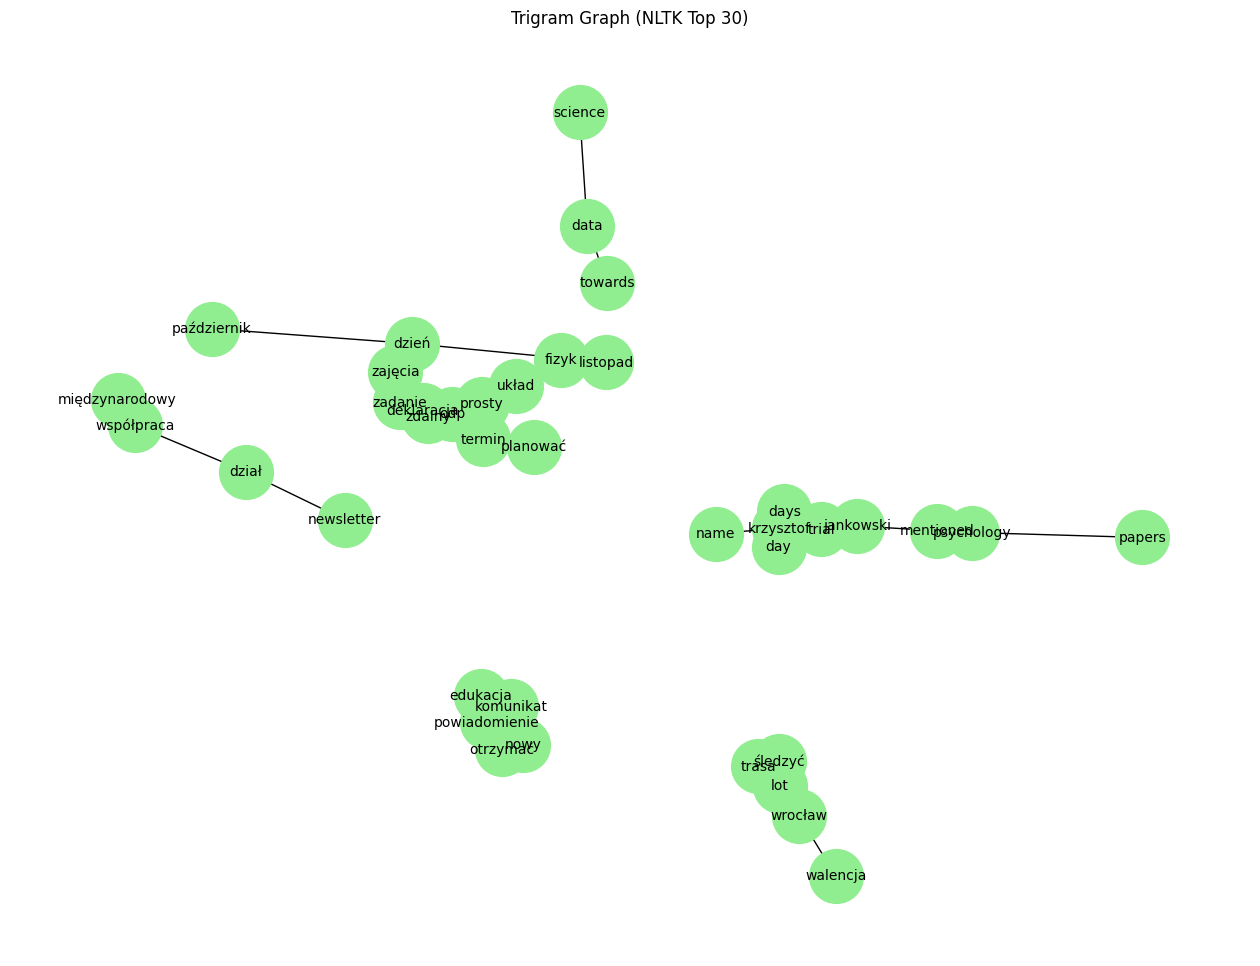

In [ ]:
plt.figure(figsize=(16, 12))

G = nx.DiGraph()
for (w1, w2, w3), count in trigram_counts:
    # chain connections: w1->w2, w2->w3
    G.add_edge(w1, w2, weight=count)
    G.add_edge(w2, w3, weight=count)

pos = nx.spring_layout(G, k=0.6)

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightgreen")
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=14)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Trigram Graph (NLTK Top 30)")
plt.axis("off")
plt.show()